# Images Clasification Project: Animals Classification
- **Name:** Muhammad Abdiel Al Hafiz
- **Email:** hafd324@gmail.com
- **Dicoding ID:** hafdiel

## Import Packages & Library

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hafizabdiel","key":"c65d957427002e6f523e0b8f6cd75acc"}'}

In [3]:
!rm -rf animal-image-classification-dataset/

In [4]:
!kaggle datasets download -d piyushkumar18/animal-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/piyushkumar18/animal-image-classification-dataset
License(s): unknown
100% 1.47G/1.47G [00:29<00:00, 60.3MB/s]
100% 1.47G/1.47G [00:29<00:00, 53.0MB/s]


In [5]:
!unzip animal-image-classification-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Animal Image Dataset/panda/panda_00392.jpg  
  inflating: Animal Image Dataset/panda/panda_00393.jpg  
  inflating: Animal Image Dataset/panda/panda_00394.jpg  
  inflating: Animal Image Dataset/panda/panda_00395.jpg  
  inflating: Animal Image Dataset/panda/panda_00396.jpg  
  inflating: Animal Image Dataset/panda/panda_00397.jpg  
  inflating: Animal Image Dataset/panda/panda_00398.jpg  
  inflating: Animal Image Dataset/panda/panda_00399.jpg  
  inflating: Animal Image Dataset/panda/panda_00400.jpg  
  inflating: Animal Image Dataset/panda/panda_00401.jpg  
  inflating: Animal Image Dataset/panda/panda_00402.jpg  
  inflating: Animal Image Dataset/panda/panda_00403.jpg  
  inflating: Animal Image Dataset/panda/panda_00404.jpg  
  inflating: Animal Image Dataset/panda/panda_00405.jpg  
  inflating: Animal Image Dataset/panda/panda_00406.jpg  
  inflating: Animal Image Dataset/panda/panda_00407.jpg  
  inflating: Animal I

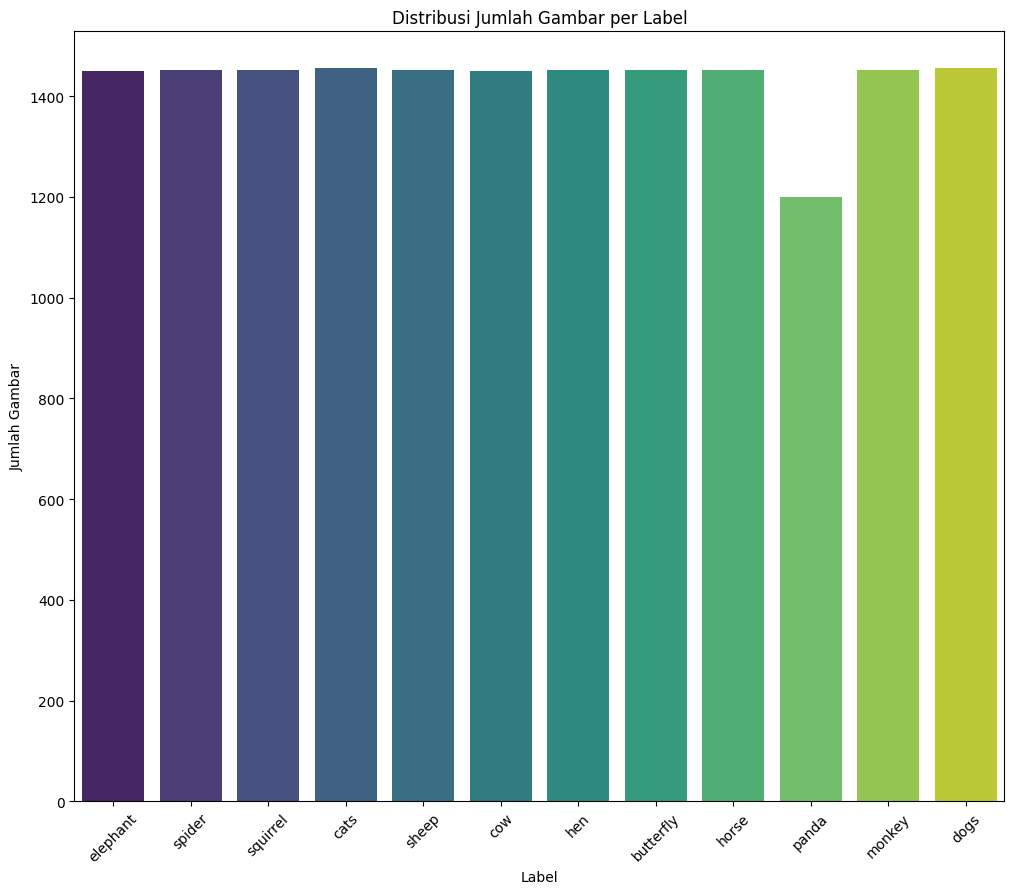

In [6]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

base_dir = '/content/Animal Image Dataset'

label_counts = {}

for label_name in os.listdir(base_dir):
    label_path = os.path.join(base_dir, label_name)

    if os.path.isdir(label_path):
        num_images = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])
        label_counts[label_name] = num_images

df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

plt.figure(figsize=(12, 10))
sns.barplot(x='Label', y='Count', data=df, palette='viridis')
plt.title('Distribusi Jumlah Gambar per Label')
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.show()


In [7]:
print("Jumlah gambar per label:")
for label, count in label_counts.items():
  if count >= 1400:
    print(f"{label}: {count}")

Jumlah gambar per label:
elephant: 1450
spider: 1452
squirrel: 1452
cats: 1456
sheep: 1452
cow: 1451
hen: 1452
butterfly: 1452
horse: 1452
monkey: 1452
dogs: 1456


### Data Loading

Out of 12 classes, only 10 classes will be used.

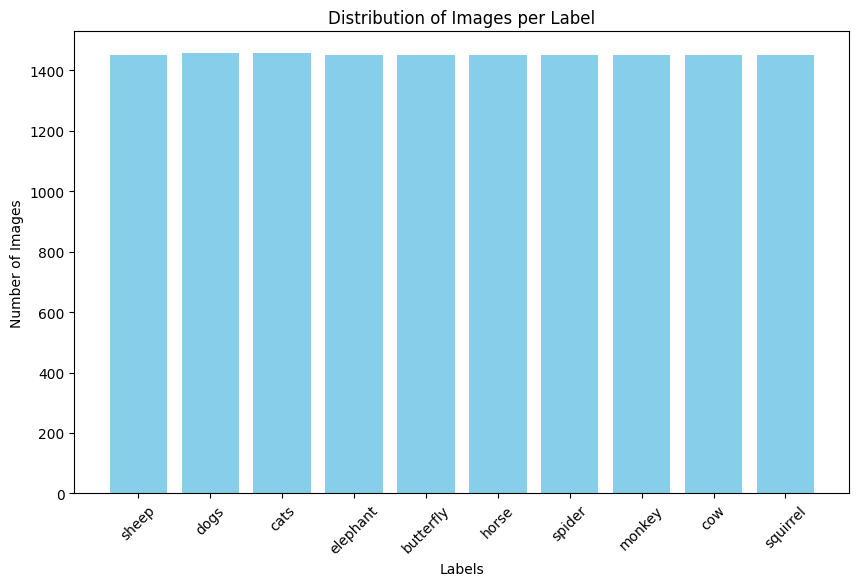

In [8]:
dataset_dir = '/content/Animal Image Dataset'
desired_labels = ['sheep', 'dogs', 'cats', 'elephant', 'butterfly', 'horse', 'spider', 'monkey', 'cow', 'squirrel']

label_counts = {}

for label in desired_labels:
    label_path = os.path.join(dataset_dir, label)
    if os.path.isdir(label_path):
        label_counts[label] = len(os.listdir(label_path))

label_counts = {label: count for label, count in label_counts.items() if count > 0}

labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Label')
plt.xticks(rotation=45)
plt.show()

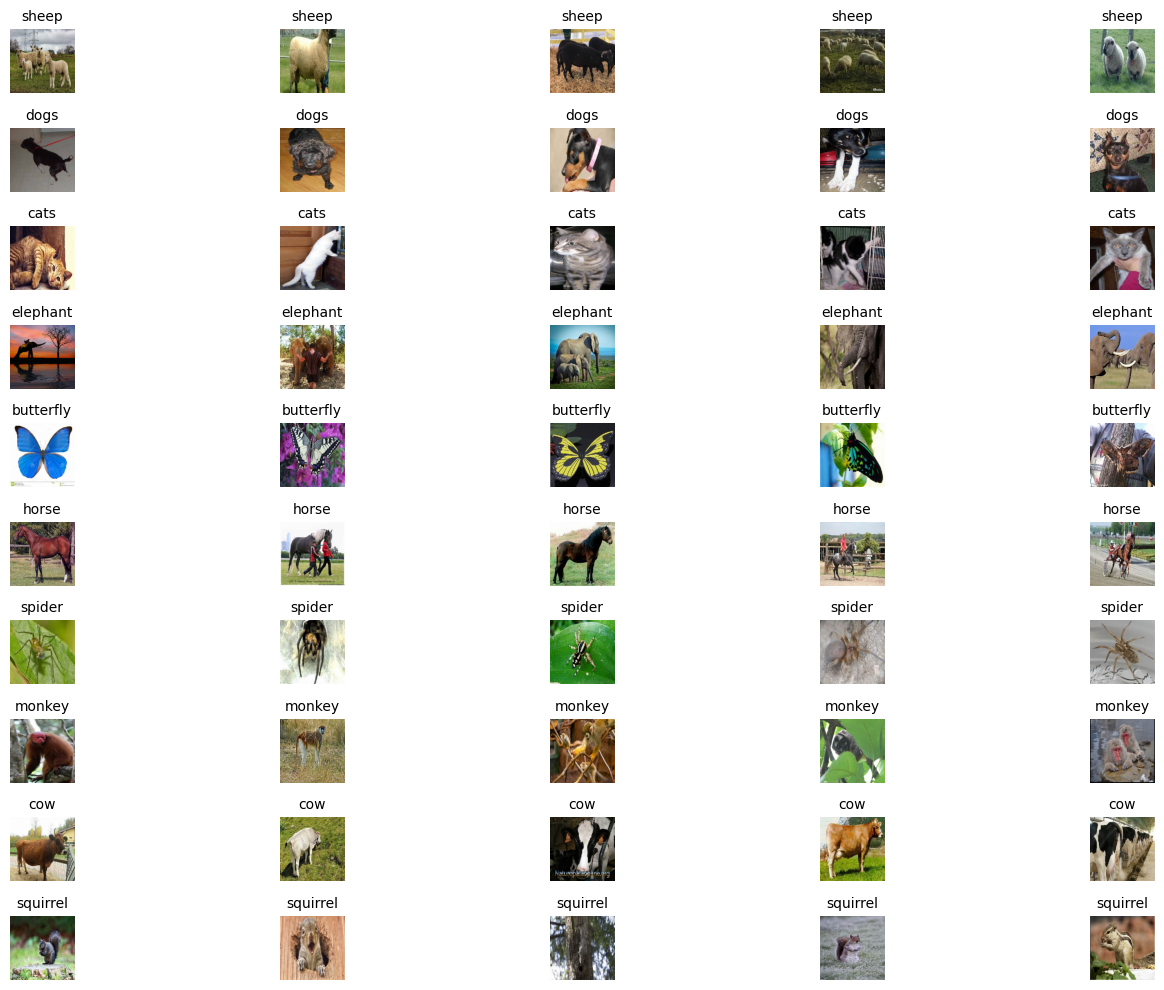

In [9]:
labels = ['sheep', 'dogs', 'cats', 'elephant', 'butterfly', 'horse', 'spider', 'monkey', 'cow', 'squirrel']
dataset_path = '/content/Animal Image Dataset'

def display_images_for_labels(labels, dataset_path, num_images=5):
    plt.figure(figsize=(15, 10))

    for i, label in enumerate(labels):
        label_path = os.path.join(dataset_path, label)
        images = os.listdir(label_path)

        selected_images = random.sample(images, num_images)

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(label_path, img_name)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0

            ax = plt.subplot(len(labels), num_images, i * num_images + j + 1)
            ax.axis('off')
            ax.imshow(img_array)
            ax.set_title(f"{label}", fontsize=10)

    plt.tight_layout()
    plt.show()

display_images_for_labels(labels, dataset_path)

### Data Preprocessing

#### Split Dataset

##### Split the train set and test set 80/20

In [10]:
dataset_dir = '/content/Animal Image Dataset'
desired_labels = ['sheep', 'dogs', 'cats', 'elephant', 'butterfly', 'horse', 'spider', 'monkey', 'cow', 'squirrel']

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(dataset_dir):
    for name in files:
        label = os.path.basename(path)
        if label in desired_labels:
            full_path.append(os.path.join(path, name))
            labels.append(label)
            file_name.append(name)

df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

print(df.groupby(['labels']).size())

labels
butterfly    1452
cats         1456
cow          1451
dogs         1456
elephant     1450
horse        1452
monkey       1452
sheep        1452
spider       1452
squirrel     1452
dtype: int64


In [11]:
X = df['path']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [12]:
print('train size', len(df_tr))
print('test size', len(df_te))

train size 11620
test size 2905


In [13]:
datasource_path = "/content/Animal Image Dataset"
dataset_path = "/content/Animals_Dataset"

def move_files(df, source_path, target_path):
    for index, row in df.iterrows():
        file_path = row['path']
        label = row['labels']
        file_set = row['set']

        dest_dir = os.path.join(target_path, file_set, label)
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)

        destination_file_name = os.path.basename(file_path)
        file_dest = os.path.join(dest_dir, destination_file_name)

        if not os.path.exists(file_dest):
            shutil.copy2(file_path, file_dest)

move_files(df_tr, datasource_path, dataset_path)
move_files(df_te, datasource_path, dataset_path)

print("Data telah dipindahkan dan dipisahkan menjadi train dan test.")

Data telah dipindahkan dan dipisahkan menjadi train dan test.


#### Image Data Generator

In [14]:
TRAIN_DIR = '/content/Animals_Dataset/train/'
TEST_DIR = '/content/Animals_Dataset/test/'

train_sheep = os.path.join(TRAIN_DIR, 'sheep')
train_dogs = os.path.join(TRAIN_DIR, 'dogs')
train_cats = os.path.join(TRAIN_DIR, 'cats')
train_elephant = os.path.join(TRAIN_DIR, 'elephant')
train_butterfly = os.path.join(TRAIN_DIR, 'butterfly')
train_horse = os.path.join(TRAIN_DIR, 'horse')
train_spider = os.path.join(TRAIN_DIR, 'spider')
train_monkey = os.path.join(TRAIN_DIR, 'monkey')
train_cow = os.path.join(TRAIN_DIR, 'cow')
train_squirrel = os.path.join(TRAIN_DIR, 'squirrel')

test_sheep = os.path.join(TEST_DIR, 'sheep')
test_dogs = os.path.join(TEST_DIR, 'dogs')
test_cats = os.path.join(TEST_DIR, 'cats')
test_elephant = os.path.join(TEST_DIR, 'elephant')
test_butterfly = os.path.join(TEST_DIR, 'butterfly')
test_horse = os.path.join(TEST_DIR, 'horse')
test_spider = os.path.join(TEST_DIR, 'spider')
test_monkey = os.path.join(TEST_DIR, 'monkey')
test_cow = os.path.join(TEST_DIR, 'cow')
test_squirrel = os.path.join(TEST_DIR, 'squirrel')

print("Jumlah foto 'sheep' di training set:", len(os.listdir(train_sheep)))
print("Jumlah foto 'dogs' di training set:", len(os.listdir(train_dogs)))
print("Jumlah foto 'cats' di training set:", len(os.listdir(train_cats)))
print("Jumlah foto 'elephant' di training set:", len(os.listdir(train_elephant)))
print("Jumlah foto 'butterfly' di training set:", len(os.listdir(train_butterfly)))
print("Jumlah foto 'horse' di training set:", len(os.listdir(train_horse)))
print("Jumlah foto 'spider' di training set:", len(os.listdir(train_spider)))
print("Jumlah foto 'monkey' di training set:", len(os.listdir(train_monkey)))
print("Jumlah foto 'cow' di training set:", len(os.listdir(train_cow)))
print("Jumlah foto 'squirrel' di training set:", len(os.listdir(train_squirrel)))

print("Jumlah foto 'sheep' di test set:", len(os.listdir(test_sheep)))
print("Jumlah foto 'dogs' di test set:", len(os.listdir(test_dogs)))
print("Jumlah foto 'cats' di test set:", len(os.listdir(test_cats)))
print("Jumlah foto 'elephant' di test set:", len(os.listdir(test_elephant)))
print("Jumlah foto 'butterfly' di test set:", len(os.listdir(test_butterfly)))
print("Jumlah foto 'horse' di test set:", len(os.listdir(test_horse)))
print("Jumlah foto 'spider' di test set:", len(os.listdir(test_spider)))
print("Jumlah foto 'monkey' di test set:", len(os.listdir(test_monkey)))
print("Jumlah foto 'cow' di test set:", len(os.listdir(test_cow)))
print("Jumlah foto 'squirrel' di test set:", len(os.listdir(test_squirrel)))


Jumlah foto 'sheep' di training set: 1176
Jumlah foto 'dogs' di training set: 1179
Jumlah foto 'cats' di training set: 1165
Jumlah foto 'elephant' di training set: 1154
Jumlah foto 'butterfly' di training set: 1147
Jumlah foto 'horse' di training set: 1164
Jumlah foto 'spider' di training set: 1159
Jumlah foto 'monkey' di training set: 1185
Jumlah foto 'cow' di training set: 1141
Jumlah foto 'squirrel' di training set: 1150
Jumlah foto 'sheep' di test set: 276
Jumlah foto 'dogs' di test set: 277
Jumlah foto 'cats' di test set: 291
Jumlah foto 'elephant' di test set: 296
Jumlah foto 'butterfly' di test set: 305
Jumlah foto 'horse' di test set: 288
Jumlah foto 'spider' di test set: 293
Jumlah foto 'monkey' di test set: 267
Jumlah foto 'cow' di test set: 310
Jumlah foto 'squirrel' di test set: 302


In [15]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    class_mode='categorical',
    color_mode="rgb",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=IMG_SIZE,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
)

Found 11620 images belonging to 10 classes.
Found 2905 images belonging to 10 classes.


In [16]:
print("classes: ", train_generator.class_indices)

classes:  {'butterfly': 0, 'cats': 1, 'cow': 2, 'dogs': 3, 'elephant': 4, 'horse': 5, 'monkey': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


## Modelling

### **Model Exp 1**

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [18]:
input_shape = (224, 224, 3)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

model_1 = Sequential([
    Input(shape=input_shape),
    base_model,
    Conv2D(1024, (4, 4),padding='same', activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256),
    BatchNormalization(),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

model_1.compile(optimizer=Adam(learning_rate=1e-3, clipnorm=1.0),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

model_1.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 1024)          │      20,972,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,938,826 (125.65 MB)

 Trainable params: 30,678,282 (117.03 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [19]:
def cyclic_lr(epoch, lr):
    base_lr = 1e-5
    max_lr = 1e-3
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [20]:
callbacks = [
    LearningRateScheduler(cyclic_lr),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model_1.keras', monitor='val_loss', save_best_only=True, verbose=1, mode='min')
]

In [21]:
class stopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') >= 0.98 and logs.get('loss') < 0.10):
      print('Akurasi di atas 98%, stop training')
      self.model.stop_training = True

stop_train = stopTraining()

import time
class TimeHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.times = []

  def on_epoch_begin(self, epoch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs={}):
    self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [22]:
count_butterfly = len(os.listdir(train_butterfly))
count_cats = len(os.listdir(train_cats))
count_cow = len(os.listdir(train_cow))
count_dogs = len(os.listdir(train_dogs))
count_elephant = len(os.listdir(train_elephant))
count_horse = len(os.listdir(train_horse))
count_monkey = len(os.listdir(train_monkey))
count_sheep = len(os.listdir(train_sheep))
count_spider = len(os.listdir(train_spider))
count_squirrel = len(os.listdir(train_squirrel))

total_images = (count_butterfly + count_cats + count_cow +
                count_dogs + count_elephant + count_horse +
                count_monkey + count_sheep + count_spider + count_squirrel)

weight_butterfly = (1 / count_butterfly) * total_images / 10.0
weight_cats = (1 / count_cats) * total_images / 10.0
weight_cow = (1 / count_cow) * total_images / 10.0
weight_dogs = (1 / count_dogs) * total_images / 10.0
weight_elephant = (1 / count_elephant) * total_images / 10.0
weight_horse = (1 / count_horse) * total_images / 10.0
weight_monkey = (1 / count_monkey) * total_images / 10.0
weight_sheep = (1 / count_sheep) * total_images / 10.0
weight_spider = (1 / count_spider) * total_images / 10.0
weight_squirrel = (1 / count_squirrel) * total_images / 10.0

class_weights = {
    0: weight_butterfly,
    1: weight_cats,
    2: weight_cow,
    3: weight_dogs,
    4: weight_elephant,
    5: weight_horse,
    6: weight_monkey,
    7: weight_sheep,
    8: weight_spider,
    9: weight_squirrel
}

print("Class Weights:", class_weights)

Class Weights: {0: 1.013077593722755, 1: 0.9974248927038627, 2: 1.01840490797546, 3: 0.9855810008481765, 4: 1.0069324090121317, 5: 0.9982817869415808, 6: 0.980590717299578, 7: 0.9880952380952381, 8: 1.002588438308887, 9: 1.0104347826086957}


In [23]:
%time

history_1 = model_1.fit(train_generator,
                        epochs = 100,
                        batch_size = BATCH_SIZE,
                        validation_data=test_generator,
                        class_weight = class_weights,
                        callbacks=[callbacks, stop_train, time_callback]
                      )

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.5789 - loss: 1.3714
Epoch 1: val_loss improved from inf to 0.22868, saving model to best_model_1.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.5799 - loss: 1.3682 - val_accuracy: 0.9294 - val_loss: 0.2287 - learning_rate: 1.0000e-05
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.8999 - loss: 0.3162
Epoch 2: val_loss improved from 0.22868 to 0.16740, saving model to best_model_1.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.8999 - loss: 0.3161 - val_accuracy: 0.9466 - val_loss: 0.1674 - learning_rate: 1.0495e-05
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.9215 - loss: 0.2572
Epoch 3: val_loss improved from 0.16740 to 0.14861, saving model to best_model_1.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9215 - loss: 0.2572 - val_accuracy: 0.9539 - val_loss: 0.1486 - learning_rate: 1.0990e-05
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/

## Evaluation & Visualization

### **Model Exp 1**

In [24]:
test_generator.reset()

train_acc = history_1.history['accuracy'][-1]
val_acc = history_1.history['val_accuracy'][-1]
test_loss, test_accuracy = model_1.evaluate(test_generator)

print('Evaluasi Model 1')
print(f"Final Training Accuracy: {train_acc:.2f}")
print(f"Final Validation Accuracy: {val_acc:.2f}")
print(f'Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}')

2905/2905 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - accuracy: 0.9573 - loss: 0.1190
Evaluasi Model 1
Final Training Accuracy: 0.98
Final Validation Accuracy: 0.95
Test Loss: 0.14, Test Accuracy: 0.95


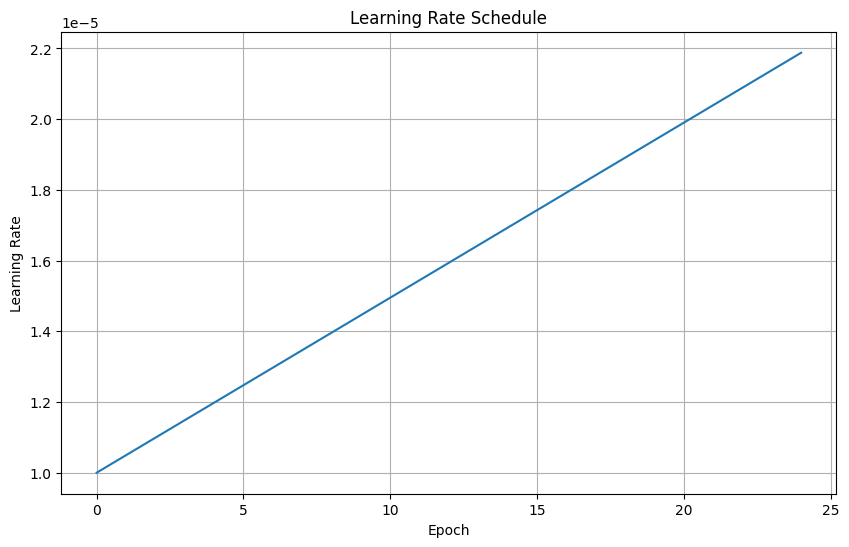

In [50]:
def cyclic_lr(epoch):
    base_lr = 1e-5
    max_lr = 1e-3
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

epochs = range(25)
lrs = [cyclic_lr(epoch) for epoch in epochs]

plt.figure(figsize=(10, 6))
plt.plot(epochs, lrs)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

### Training and Validation Accuracy

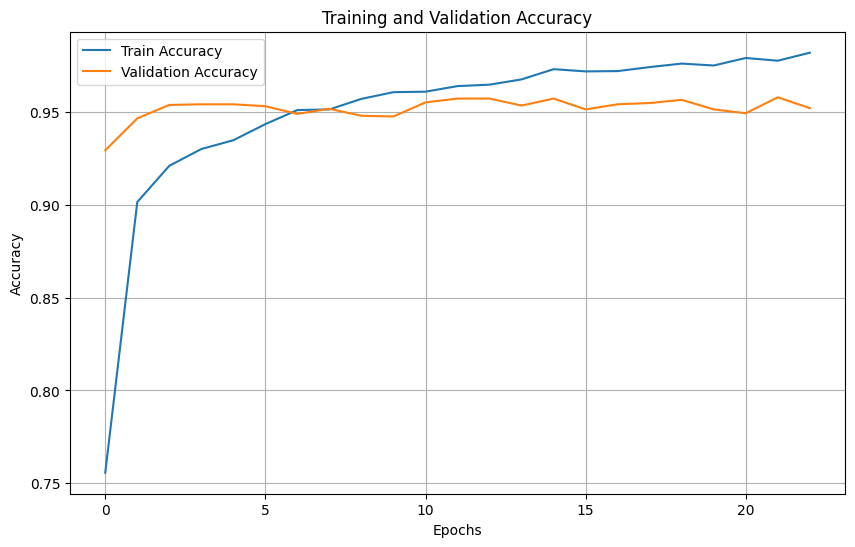

In [28]:
plt.figure(figsize=(10,6))
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Training and Validation Loss

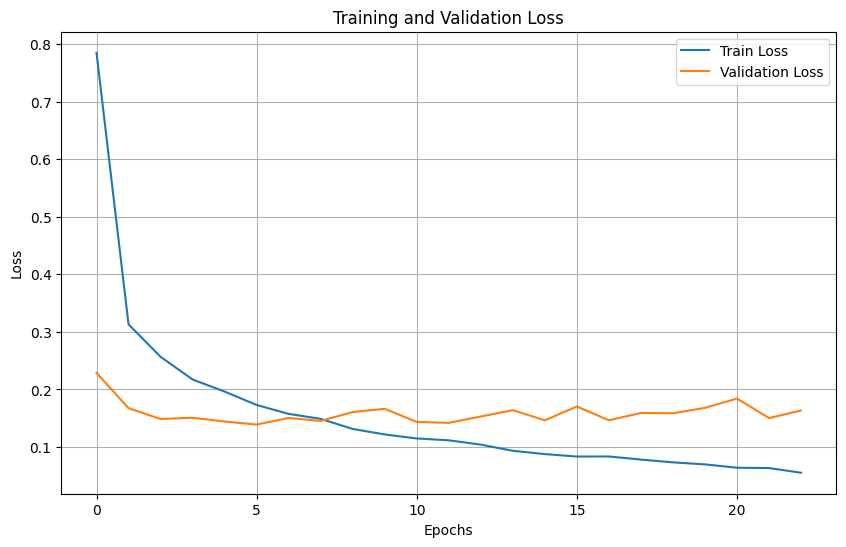

In [29]:
plt.figure(figsize=(10,6))
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

### Confusion Matrix



              precision    recall  f1-score   support

   butterfly     0.9489    0.9738    0.9612       305
        cats     0.9790    0.9622    0.9705       291
         cow     0.9180    0.9032    0.9106       310
        dogs     0.9431    0.9567    0.9498       277
    elephant     0.9603    0.9797    0.9699       296
       horse     0.9262    0.9583    0.9420       288
      monkey     0.9638    0.9963    0.9797       267
       sheep     0.9392    0.8949    0.9165       276
      spider     0.9858    0.9488    0.9670       293
    squirrel     0.9699    0.9603    0.9651       302

    accuracy                         0.9532      2905
   macro avg     0.9534    0.9534    0.9532      2905
weighted avg     0.9533    0.9532    0.9531      2905



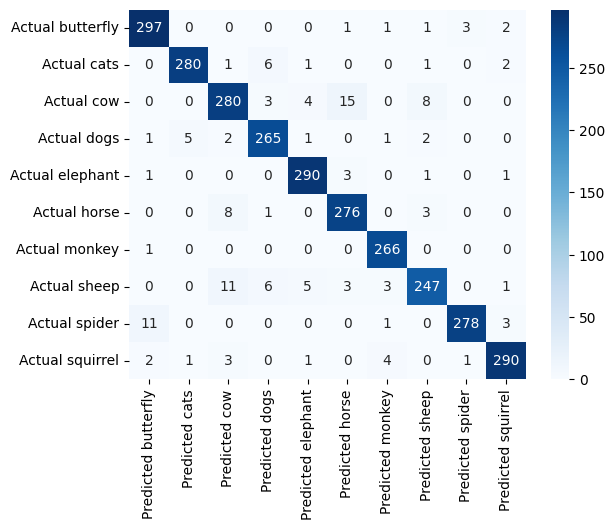

In [30]:
test_generator.reset()

preds_1 = model_1.predict(test_generator, verbose=0)
preds_1 = preds_1.argmax(axis=1)

labels = ['butterfly', 'cats', 'cow', 'dogs', 'elephant', 'horse', 'monkey', 'sheep', 'spider', 'squirrel']
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=range(len(labels))),
                  index=[f"Actual {label}" for label in labels],
                  columns=[f"Predicted {label}" for label in labels])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

print("\n")
print(classification_report(y_true=test_generator.classes, y_pred=preds_1, target_names=labels, digits=4))


## Model Convertion

### Saved Model

In [31]:
saved_model_path = './saved_model_1/animals_model_1'
model_1.export(saved_model_path)
print(f"Model disimpan dalam format SavedModel di: {saved_model_path}")

Saved artifact at './saved_model_1/animals_model_1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139543497693088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543446714000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543446711184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543446711712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543446712944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543446714176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543447274592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543447277936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543447275472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543447275824: TensorSpec(shape=(), dtype=tf.resource, name=No

### TF-Lite

In [32]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

tflite_model_dir = './saved_model_1/tflite_model/'
os.makedirs(tflite_model_dir, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

tflite_model_path = os.path.join(tflite_model_dir, 'animals_model_1.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

labels = ['sheep', 'dogs', 'cats', 'elephant', 'butterfly', 'horse', 'spider', 'monkey', 'cow', 'squirrel']

label_file_path = os.path.join(tflite_model_dir, 'label.txt')
with open(label_file_path, 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

print(f"Model disimpan dalam format TF-Lite di: {tflite_model_path}")
print(f"Labels disimpan dalam file: {label_file_path}")

Saved artifact at '/tmp/tmpsn9kcume'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139543497693088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543446714000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543446711184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543446711712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543446712944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543446714176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543447274592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543447277936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543447275472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543447275824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139543447

### Tensorflow.js

In [33]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 75.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-d

In [34]:
import tensorflowjs as tfjs

tfjs_model_dir = './saved_model_1/tfjs_model/'
os.makedirs(tfjs_model_dir, exist_ok=True)

tfjs_model_path = os.path.join(tfjs_model_dir, 'model')
tfjs.converters.save_keras_model(model_1, tfjs_model_path)

failed to lookup keras version from the file,
    this is likely a weight only file


In [35]:
folder_to_zip = './saved_model_1'
zip_file_path = './saved_model_1.zip'

shutil.make_archive(base_name=zip_file_path.replace('.zip', ''), format='zip', root_dir=os.path.dirname(folder_to_zip), base_dir=os.path.basename(folder_to_zip))

print(f"Folder '{folder_to_zip}' telah dikompres menjadi '{zip_file_path}'.")

Folder './saved_model_1' telah dikompres menjadi './saved_model_1.zip'.


In [36]:
file_size = os.path.getsize(zip_file_path)
file_size_mb = file_size / (1024 * 1024)

print(f"Ukuran file ZIP: {file_size_mb:.2f} MB")

Ukuran file ZIP: 463.58 MB


In [37]:
from google.colab import files

zip_file_path = './saved_model_1.zip'
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference with Saved Model

In [47]:
def predict_images_in_folder(folder_path):
    model_path = './saved_model_1/animals_model_1'
    model = tf.saved_model.load(model_path)
    infer = model.signatures['serving_default']

    labels = ['butterfly', 'cats', 'cow', 'dogs', 'elephant',
              'horse', 'monkey', 'sheep', 'spider', 'squirrel']

    images = []
    titles = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image = Image.open(file_path)
            image = image.resize((224, 224))
            image_array = np.array(image).astype(np.float32) / 255.0
            image_array = np.expand_dims(image_array, axis=0)

            predictions = infer(tf.convert_to_tensor(image_array, dtype=tf.float32))['output_0']
            predicted_index = np.argmax(predictions.numpy(), axis=1)[0]
            predicted_probability = np.max(predictions.numpy()) * 100
            predicted_label = labels[predicted_index]

            images.append(image)
            titles.append(f"{predicted_label} ({predicted_probability:.2f}%)")

    num_images = len(images)
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(titles[i])

    plt.suptitle("Prediction", y=0.75)
    plt.subplots_adjust(top=0.75)
    plt.show()

### Input New Data

In [39]:
zip_file_path = '/content/predict.zip'
extract_to = '/content/new_data'

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"File diekstrak ke {extract_to}")

File diekstrak ke /content/new_data


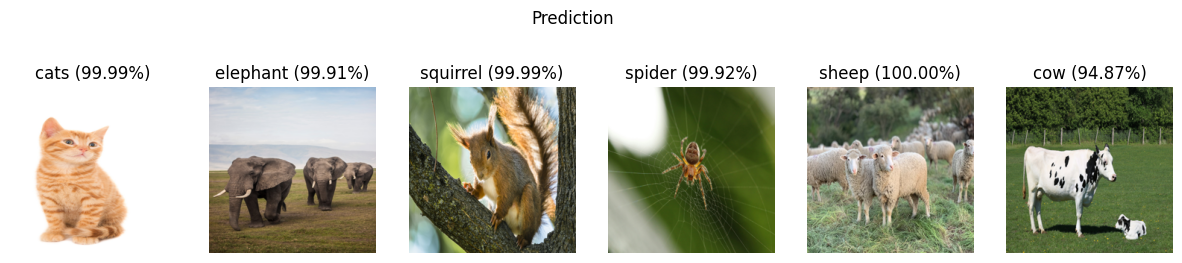

In [48]:
folder_path = '/content/new_data'
predict_images_in_folder(folder_path)

### Create requirements.txt

In [49]:
pip freeze > requirements.txt